## Train CFM

In [11]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [2600, 3300]},  
                  cuts_sideband_high = {'mjj': [3700, 5000]}, 
                  dim_input = 5,
                  num_dijets = 125000,  
                  # training params:   
                  DEVICE = 'cuda:1',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 20,
                  min_epochs = 100,
                  data_split_fracs = [0.6, 0.2, 0.2],
                  lr = 1e-3,
                  optimizer = 'Adam',
                  fix_seed = 1234,
                  # model params:
                  MODEL = 'MLP',
                  dim_hidden = 128,
                  num_layers = 5,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 500
                )

configs.set_workdir(path='../../results', save_config=True)

#=====================================================================================
INFO: created directory: ../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.10_19h36
#=====================================================================================
+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          | ['normalize', 'logit_tr

In [12]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsHighLevelDataset(configs)
cfm = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader(lhco, configs), 
                         configs = configs)

#...train model:

cfm.train()

number of training parameters: 67589
number of training parameters: 67589
number of training parameters: 67589
number of training parameters: 67589
start training...
start training...
start training...
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.6/0.2/0.2
INFO: train size: 75000, validation size: 25000, testing sizes: 25000


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.1723326284463714, valid loss: 0.16561339704357844  (min valid loss: 0.16561339704357844)
	Epoch: 1, train loss: 0.1723326284463714, valid loss: 0.16561339704357844  (min valid loss: 0.16561339704357844)
	Epoch: 1, train loss: 0.1723326284463714, valid loss: 0.16561339704357844  (min valid loss: 0.16561339704357844)
	Epoch: 1, train loss: 0.1723326284463714, valid loss: 0.16561339704357844  (min valid loss: 0.16561339704357844)
	Epoch: 21, train loss: 0.1620562955433009, valid loss: 0.16224832741581666  (min valid loss: 0.1617641500672516)
	Epoch: 21, train loss: 0.1620562955433009, valid loss: 0.16224832741581666  (min valid loss: 0.1617641500672516)
	Epoch: 21, train loss: 0.1620562955433009, valid loss: 0.16224832741581666  (min valid loss: 0.1617641500672516)
	Epoch: 21, train loss: 0.1620562955433009, valid loss: 0.16224832741581666  (min valid loss: 0.1617641500672516)
	Epoch: 41, train loss: 0.1634073107420994, valid loss: 0.16131590185116745  (min valid 

In [23]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             configs=configs, 
                             preprocessor= PreProcessLHCOlympicsHighLevelData,
                             postprocessor= PostProcessLHCOlympicsHighLevelData,
                             best_epoch_model=True)

pipeline.generate_samples(input_source=lhco.source)

INFO: neural ODE solver with midpoint method and steps=500


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


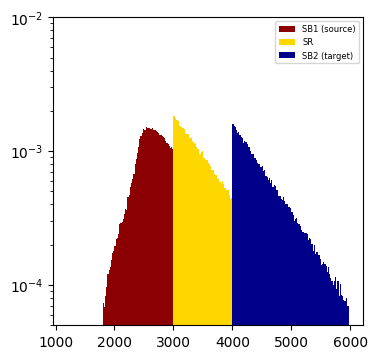

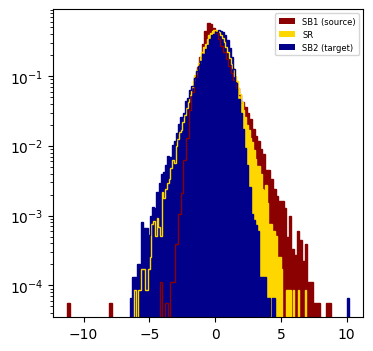

In [32]:
import matplotlib.pyplot as plt

log = True
bins = np.arange(1200,6000,20)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source[...,0], bins=bins, histtype='stepfilled', color='darkred', label='SB1 (source)', log=log, density=True)
plt.hist(lhco.background[...,0], bins=bins, histtype='stepfilled', color='gold', label='SR', log=log, density=True)
plt.hist(lhco.target[...,0], bins=bins, histtype='stepfilled', color='darkblue', label='SB2 (target)', log=log, density=True)
ax.set_ylim(5e-5, 1e-2)
plt.legend(fontsize=6)

log = True
bins = 100

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source_preprocess[...,0], bins=bins, histtype='stepfilled', color='darkred', label='SB1 (source)', log=log, density=True)
plt.hist(lhco.background_preprocess[...,0], bins=bins, histtype='stepfilled', color='gold', label='SR', log=log, density=True)
plt.hist(lhco.target_preprocess[...,0], bins=bins, histtype='stepfilled', color='darkblue', label='SB2 (target)', log=log, density=True)
plt.hist(lhco.source_preprocess[...,0], bins=bins, histtype='step', color='darkred', log=log, density=True)
plt.hist(lhco.background_preprocess[...,0], bins=bins, histtype='step', color='gold', log=log, density=True)
plt.hist(lhco.target_preprocess[...,0], bins=bins, histtype='step', color='darkblue', log=log, density=True)
plt.legend(fontsize=6)

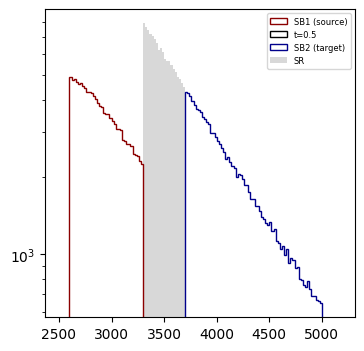

In [31]:
import matplotlib.pyplot as plt

log = True
density = False
bins = np.arange(2500, 5200, 20)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source[...,0], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=density)
plt.hist(pipeline.trajectories[-1][...,0], bins=bins, histtype='step', color='k', label='t=0.5', log=log, density=density)
plt.hist(lhco.target[...,0], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=density)
plt.hist(lhco.background[...,0],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=density)
# ax.set_ylim(5e-5, 1e-2)
plt.legend(fontsize=6)

# log = True
# bins = 100

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# plt.hist(lhco.source[...,1], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
# # plt.hist(pipeline.quarter[...,1], bins=bins, histtype='step', color='darkred', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(pipeline.midway[...,1], bins=bins, histtype='step', color='k', label='t=0.5', log=log, density=True)
# # plt.hist(pipeline.target[...,1], bins=bins, histtype='step', color='purple', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(lhco.target[...,1], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
# plt.hist(lhco.background[...,1],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
# plt.legend(fontsize=6)


# log = True
# bins = 100

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# plt.hist(lhco.source[...,2], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
# # plt.hist(pipeline.quarter[...,2], bins=bins, histtype='step', color='darkred', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(pipeline.midway[...,2], bins=bins, histtype='step', color='k', label='t=0.5', log=log, density=True)
# # plt.hist(pipeline.target[...,2], bins=bins, histtype='step', color='purple', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(lhco.target[...,2], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
# plt.hist(lhco.background[...,2],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
# plt.legend(fontsize=6)

# log = True
# bins = 100

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# plt.hist(lhco.source[...,3], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
# # plt.hist(pipeline.quarter[...,3], bins=bins, histtype='step', color='darkred', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(pipeline.midway[...,3], bins=bins, histtype='step', color='k', label='t=0.5', log=log, density=True)
# # plt.hist(pipeline.target[...,3], bins=bins, histtype='step', color='purple', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(lhco.target[...,3], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
# plt.hist(lhco.background[...,3],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
# plt.legend(fontsize=6)

# log = True
# bins = 100

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# plt.hist(lhco.source[...,4], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
# # plt.hist(pipeline.quarter[...,4], bins=bins, histtype='step', color='darkred', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(pipeline.midway[...,4], bins=bins, histtype='step', color='k', label='t=0.5', log=log, density=True)
# # plt.hist(pipeline.target[...,4], bins=bins, histtype='step', color='purple', ls=':', label='t=1.0', log=log, density=True)
# plt.hist(lhco.target[...,4], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
# plt.hist(lhco.background[...,4],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
# plt.legend(fontsize=6)

# Sample from Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### 1. Load pre-trained model
promising runs:

 - LHCOlympics.CondFlowMatch.MLP.2023.11.01_22h09
 

In [ ]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.lhco_configs import LHCOlympics_MLP_CondFlowMatch as Configs

model_workdir = '../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.01_22h09'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:3'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.lhco.datasets import LHCOlympicsDataset 
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsDataset(configs)
pretrained_cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs),
                                    model = MLP(configs), 
                                    dataloader = LHCOlympicsDataLoader(lhco, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_cfm.load(model='best')

### 2. sample from loaded models

In [6]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 

pipeline = FlowMatchPipeline(trained_model=pretrained_cfm, 
                             source_input=lhco.source,
                             configs=configs, 
                             solver = 'dopri5',
                             best_epoch_model=True)

NameError: name 'pretrained_cfm' is not defined

### Plot results:

In [ ]:
import numpy as np
from utils import plot_jet_features, plot_dijet_mass

STEP = configs.num_sampling_steps/2
D_STEP = configs.num_sampling_steps/4

plot_jet_features(lhco, pipeline.trajectories, 'p_t', time_step=STEP, d_step=D_STEP, xlim=(1000, 3000, 40))
plot_jet_features(lhco, pipeline.trajectories, '\eta', time_step=STEP, d_step=D_STEP, xlim=(-3, 3, 0.05))
plot_jet_features(lhco, pipeline.trajectories, '\phi', time_step=STEP, d_step=D_STEP, xlim=(-1, 12, 0.1))
plot_jet_features(lhco, pipeline.trajectories, 'm', time_step=STEP, d_step=D_STEP, xlim=(0, 1000, 10))
plot_dijet_mass(lhco, pipeline.trajectories, bins=np.arange(2000, 10000, 20), time_step=STEP, d_step=D_STEP, figsize=(4,4))